In [ ]:
 import numpy as np
import pandas as pd

# For reproducibility
np.random.seed(42)

# Number of base samples
n_samples = 40000


# physiological features

glucose = np.random.normal(loc=140, scale=30, size=n_samples)  # mg/dL
carbs = np.random.normal(loc=50, scale=15, size=n_samples)  # grams
insulin = np.random.normal(loc=8, scale=3, size=n_samples)  # units
activity = np.random.normal(loc=30, scale=10, size=n_samples)  # minutes/day
stress = np.random.choice([0, 1], size=n_samples, p=[0.7, 0.3])  # 0 = low, 1 = high
time_of_day = np.random.choice([0, 1, 2], size=n_samples, p=[0.3, 0.4, 0.3])  # 0=morning, 1=afternoon, 2=evening


#  clinical features

age = np.random.normal(loc=55, scale=12, size=n_samples).clip(18, 90)
bmi = np.random.normal(loc=28, scale=5, size=n_samples).clip(15, 50)
hba1c = np.random.normal(loc=7.5, scale=1.2, size=n_samples).clip(4, 15)
hypertension = np.random.choice([0, 1], size=n_samples, p=[0.65, 0.35])
kidney_disease = np.random.choice([0, 1], size=n_samples, p=[0.85, 0.15])
type_diabetes = np.random.choice([1, 2], size=n_samples, p=[0.3, 0.7])
duration_since_dx = np.random.normal(loc=8, scale=6, size=n_samples).clip(0, 50)  # years


# Lifestyle features

sleep_hours = np.random.normal(loc=7, scale=1.5, size=n_samples).clip(3, 12)
diet_quality = np.random.choice([1, 2, 3], size=n_samples, p=[0.3, 0.5, 0.2])  # 1=poor, 3=good
smoking_status = np.random.choice([0, 1, 2], size=n_samples, p=[0.6, 0.25, 0.15])  # 0=non,1=former,2=current
alcohol_units_week = np.random.poisson(lam=3, size=n_samples)  # units/week
med_adherence = np.random.choice([0, 1, 2], size=n_samples, p=[0.7, 0.2, 0.1])  # 0=adherent,1=missed,2=irregular


# Time-trend glucose features

glucose_trend_3h = np.random.choice([-1, 0, 1], size=n_samples, p=[0.25, 0.5, 0.25])  # -1=falling,0=stable,1=rising
avg_glucose_7d = np.random.normal(loc=145, scale=25, size=n_samples)
time_since_last_insulin = np.random.normal(loc=4, scale=2, size=n_samples).clip(0, 24)  # hours
hyper_events_past_week = np.random.poisson(lam=2, size=n_samples)


#  probabilities for multi-class hyperglycaemia

# We'll create a continuous risk score and then map to severity categories
beta = {
    "intercept": -5,
    "glucose": 0.035,
    "carbs": 0.015,
    "insulin": -0.04,
    "activity": -0.02,
    "stress": 0.7,
    "time_afternoon": 0.25,
    "time_evening": 0.45,
    "age": 0.008,
    "bmi": 0.015,
    "hba1c": 0.35,
    "hypertension": 0.4,
    "kidney_disease": 0.6,
    "type_diabetes": 0.3,
    "duration_since_dx": 0.01,
    "sleep_hours": -0.05,
    "diet_quality": -0.1,
    "smoking_status": 0.15,
    "alcohol_units_week": 0.02,
    "med_adherence": 0.4,
    "glucose_trend_3h": 0.5,
    "avg_glucose_7d": 0.02,
    "time_since_last_insulin": 0.03,
    "hyper_events_past_week": 0.25
}

time_afternoon = (time_of_day == 1).astype(int)
time_evening = (time_of_day == 2).astype(int)

logit = (
    beta["intercept"]
    + beta["glucose"] * glucose
    + beta["carbs"] * carbs
    + beta["insulin"] * insulin
    + beta["activity"] * activity
    + beta["stress"] * stress
    + beta["time_afternoon"] * time_afternoon
    + beta["time_evening"] * time_evening
    + beta["age"] * age
    + beta["bmi"] * bmi
    + beta["hba1c"] * hba1c
    + beta["hypertension"] * hypertension
    + beta["kidney_disease"] * kidney_disease
    + beta["type_diabetes"] * (type_diabetes - 1)  # type 2 gets 0, type 1 gets coeff
    + beta["duration_since_dx"] * duration_since_dx
    + beta["sleep_hours"] * sleep_hours
    + beta["diet_quality"] * diet_quality
    + beta["smoking_status"] * smoking_status
    + beta["alcohol_units_week"] * alcohol_units_week
    + beta["med_adherence"] * med_adherence
    + beta["glucose_trend_3h"] * glucose_trend_3h
    + beta["avg_glucose_7d"] * avg_glucose_7d
    + beta["time_since_last_insulin"] * time_since_last_insulin
    + beta["hyper_events_past_week"] * hyper_events_past_week
)

prob = 1 / (1 + np.exp(-logit))


# severity categories
severity_labels = ['Hypo', 'Normal', 'Mild Hyperglycemia', 'Moderate Hyperglycemia', 'Severe Hyperglycemia']
severity_classes = [0, 1, 2, 3]
severity = np.select(
    [
        glucose < 70,
        (glucose >= 70) & (glucose < 180),
        (glucose >= 180) & (glucose < 250),
        (glucose >= 250) & (glucose < 300),
        glucose >= 300
    ],
    [0, 1, 2, 3, 4]
)


# Build DataFrame

df = pd.DataFrame({
    "glucose": glucose,
    "carbs": carbs,
    "insulin": insulin,
    "activity": activity,
    "stress": stress,
    "time_of_day": time_of_day,
    "age": age,
    "bmi": bmi,
    "hba1c": hba1c,
    "hypertension": hypertension,
    "kidney_disease": kidney_disease,
    "type_diabetes": type_diabetes,
    "duration_since_dx": duration_since_dx,
    "sleep_hours": sleep_hours,
    "diet_quality": diet_quality,
    "smoking_status": smoking_status,
    "alcohol_units_week": alcohol_units_week,
    "med_adherence": med_adherence,
    "glucose_trend_3h": glucose_trend_3h,
    "avg_glucose_7d": avg_glucose_7d,
    "time_since_last_insulin": time_since_last_insulin,
    "hyper_events_past_week": hyper_events_past_week,
    "risk_probability": prob,
    "severity_class": severity
})


# Oversample higher severity cases (2, 3, 4) for balance

high_sev_cases = df[df["severity_class"] >= 2]
extra_high_sev = high_sev_cases.sample(frac=0.2, replace=True, random_state=42)

df = pd.concat([df, extra_high_sev], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# Save dataset

df.to_csv("simulated_diabetes_data.csv", index=False)

# Summary
print(df.head())
print(f"Final dataset size: {df.shape}")
print(df["severity_class"].value_counts(normalize=True))

      glucose      carbs    insulin   activity  stress  time_of_day  \
0  154.835675  71.028862  12.586647  12.483311       1            0   
1  144.089339  47.259068   4.231344  36.366747       0            0   
2  160.232144  65.474642   7.567322  36.635735       0            2   
3  175.664187  52.069382  11.828112  47.435297       0            2   
4  148.938847  41.243162  14.381370  36.789165       1            2   

         age        bmi     hba1c  hypertension  ...  diet_quality  \
0  47.933911  34.941393  7.528641             0  ...             2   
1  72.177007  25.162625  8.269195             1  ...             2   
2  56.407219  24.136007  8.366962             0  ...             1   
3  55.635307  28.419571  8.569601             1  ...             2   
4  55.540832  26.709910  4.950930             0  ...             3   

   smoking_status  alcohol_units_week  med_adherence  glucose_trend_3h  \
0               0                   1              0                 1   
1   

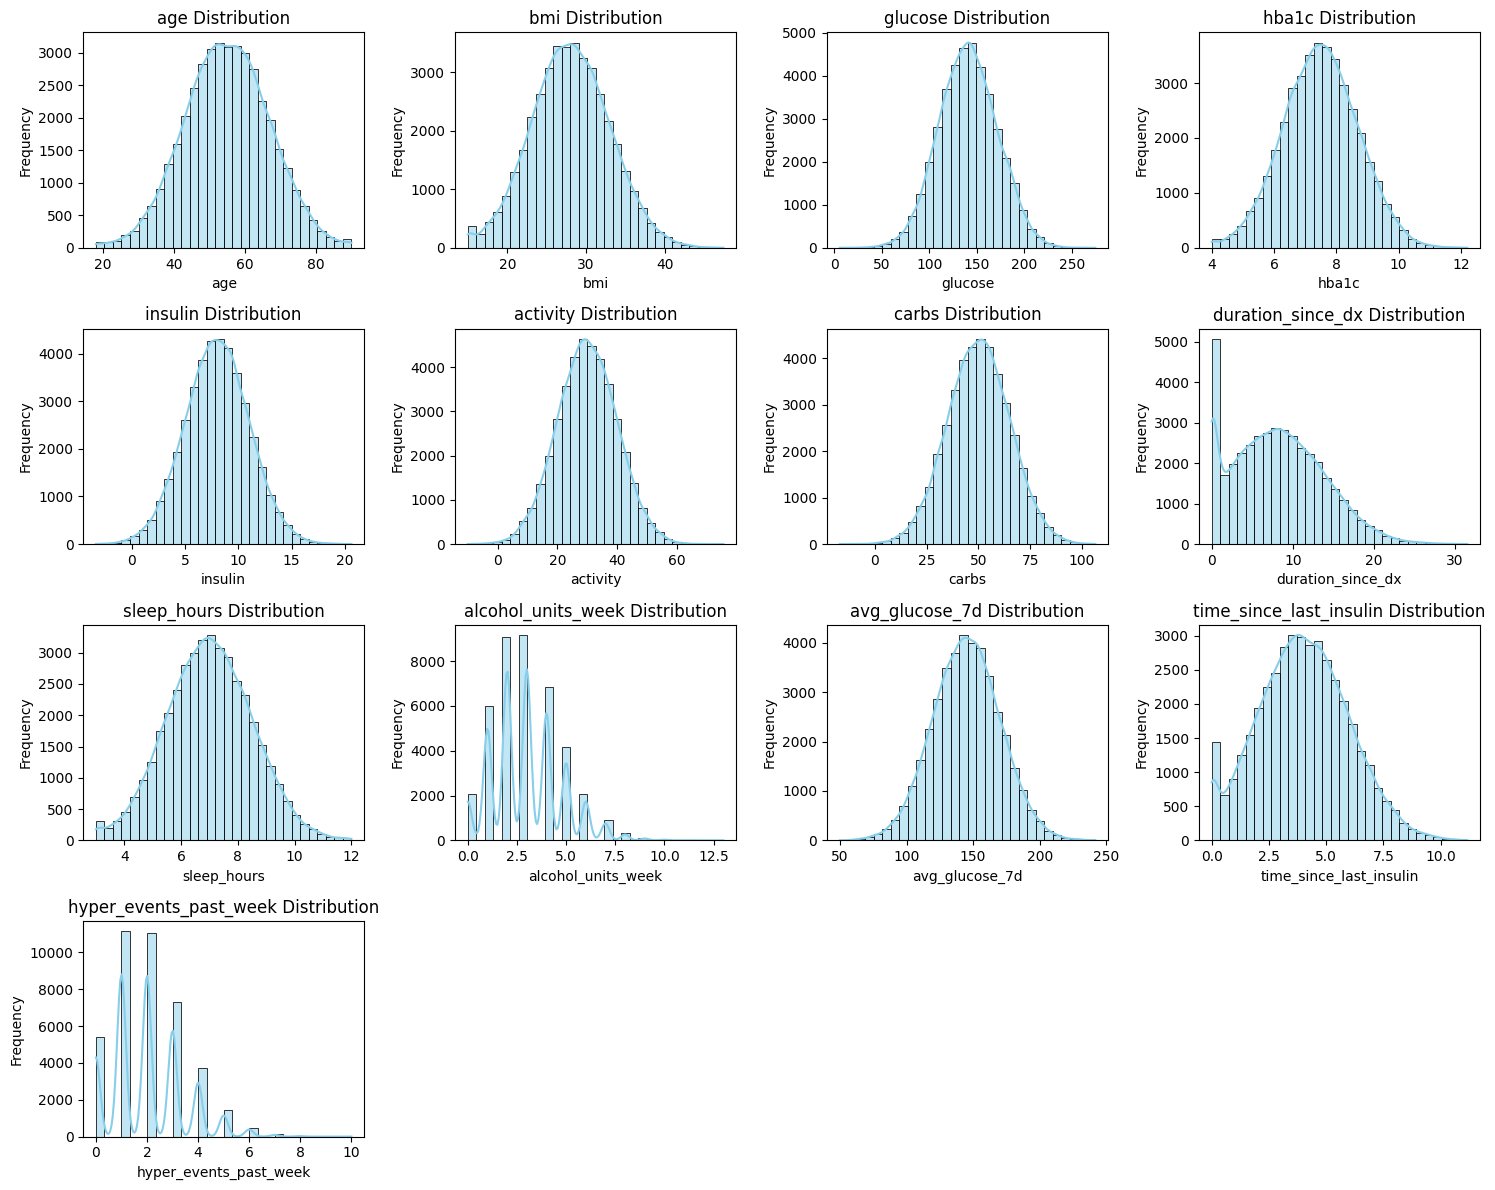

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numeric features
numeric_features = ['age', 'bmi', 'glucose', 'hba1c', 'insulin', 'activity', 'carbs', 'duration_since_dx', 'sleep_hours', 'alcohol_units_week', 'avg_glucose_7d', 'time_since_last_insulin', 'hyper_events_past_week']

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'{col} Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('numeric_features_distribution.png') # Save the figure
plt.show()

In [ ]:
%pip install colorama

In [ ]:
# logistic_regression

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Import confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import joblib
import warnings
from termcolor import colored
from colorama import init
from imblearn.over_sampling import RandomOverSampler, SMOTE # Import SMOTE
from collections import Counter # Import Counter
import numpy as np # Import numpy

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
init(autoreset=True)

# Initialize results dictionary if it doesn't exist
if 'results' not in globals():
    results = {}


# STEP 1: Load Dataset

df = pd.read_csv("simulated_diabetes_data.csv")

feature_cols = [
    "glucose", "carbs", "insulin", "activity", "stress", "time_of_day",
    "age", "bmi", "hba1c", "hypertension", "kidney_disease", "type_diabetes",
    "duration_since_dx", "sleep_hours", "diet_quality", "smoking_status",
    "alcohol_units_week", "med_adherence", "glucose_trend_3h",
    "avg_glucose_7d", "time_since_last_insulin", "hyper_events_past_week"
]

X = df[feature_cols]
y = df["severity_class"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# STEP 2: Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# STEP 3: Handle Class Imbalance

train_counts = Counter(y_train)
print(colored(f"Class distribution before balancing: {dict(train_counts)}", "cyan"))

min_samples = min(train_counts.values())

if min_samples > 1:
    try:
        k_neighbors_smote = min(min_samples - 1, 5) if min_samples > 1 else 1
        if k_neighbors_smote < 1:
             raise ValueError("Cannot apply SMOTE with less than 2 samples in the smallest class.")
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
        X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
        print(colored(" SMOTE applied successfully", "green"))
    except ValueError as e:
        print(colored(f" SMOTE failed: {e}. Using RandomOverSampler instead.", "red"))
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)
        print(colored(" RandomOverSampler applied", "green"))
else:
    print(colored(" Not enough samples in one class for SMOTE. Using RandomOverSampler.", "red"))
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)
    print(colored(" RandomOverSampler applied", "green"))

print(colored(f" Class distribution after balancing: {dict(Counter(y_train_res))}", "cyan"))



# STEP 4: Logistic Regression Model

logreg = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=2000,
    C=0.5,
    random_state=42
)

print(colored("Training Logistic Regression with scaling & saga solver...", "yellow", attrs=["bold"]))
logreg.fit(X_train_res, y_train_res) # Use resampled data for training


# STEP 5: Evaluation

y_pred = logreg.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(colored(f"Logistic Regression Accuracy: {acc:.4f}", "green", attrs=["bold"]))
print(classification_report(y_test, y_pred, zero_division=0))


# Add Logistic Regression results to the results dictionary
results["LogisticRegression"] = {
    "report": classification_report(y_test, y_pred, output_dict=True, zero_division=0),
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "pred_proba": logreg.predict_proba(X_test_scaled)
}


# STEP 6: Save Model & Coefficients

joblib.dump((logreg, scaler), "LogisticRegression_Multinomial_model.pkl")
print(colored("Model & scaler saved as LogisticRegression_Multinomial_model.pkl", "magenta", attrs=["bold"]))

# Coefficients table
coefs = logreg.coef_
classes = logreg.classes_
coef_df = pd.DataFrame(coefs.T, index=feature_cols, columns=[f"Class_{cls}" for cls in classes])

# Save coefficients with color gradient
coef_styled = coef_df.style.background_gradient(cmap="coolwarm").set_caption("Logistic Regression Coefficients")
try:
    coef_styled.to_excel("logistic_regression_coefficients_colored.xlsx", engine="openpyxl")
    print(colored("Saved logistic_regression_coefficients_colored.xlsx", "cyan"))
except ImportError:
    print(colored("Could not save coefficients to Excel. Please install openpyxl (`pip install openpyxl`).", "red"))
    coef_df.to_csv("logistic_regression_coefficients.csv")
    print(colored("Saved logistic_regression_coefficients.csv instead.", "cyan"))

Class distribution before balancing: {1: 28756, 2: 3491, 0: 330, 3: 5}
 SMOTE applied successfully
 Class distribution after balancing: {1: 28756, 2: 28756, 0: 28756, 3: 28756}
Training Logistic Regression with scaling & saga solver...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9840
              precision    recall  f1-score   support

           0       0.69      1.00      0.81        83
           1       1.00      0.98      0.99      7189
           2       0.90      1.00      0.95       873
           3       1.00      1.00      1.00         1

    accuracy                           0.98      8146
   macro avg       0.90      1.00      0.94      8146
weighted avg       0.99      0.98      0.98      8146

Model & scaler saved as LogisticRegression_Multinomial_model.pkl
Saved logistic_regression_coefficients_colored.xlsx


In [ ]:
print(df["severity_class"].value_counts(normalize=True))

severity_class
1    0.882562
2    0.107150
0    0.010140
3    0.000147
Name: proportion, dtype: float64


In [ ]:
# all_other_models.py

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from collections import Counter


init(autoreset=True)


# STEP 1: Load Dataset

df = pd.read_csv("simulated_diabetes_data.csv")

feature_cols = [
    "glucose", "carbs", "insulin", "activity", "stress", "time_of_day",
    "age", "bmi", "hba1c", "hypertension", "kidney_disease", "type_diabetes",
    "duration_since_dx", "sleep_hours", "diet_quality", "smoking_status",
    "alcohol_units_week", "med_adherence", "glucose_trend_3h",
    "avg_glucose_7d", "time_since_last_insulin", "hyper_events_past_week"
]

X = df[feature_cols]
y = df["severity_class"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# STEP 2: Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# STEP 3: Handle Class Imbalance

train_counts = Counter(y_train)
print(colored(f"Class distribution before balancing: {dict(train_counts)}", "cyan"))

if min(train_counts.values()) > 1:
    try:
        smote = SMOTE(k_neighbors=2, random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
        print(colored(" SMOTE applied successfully", "green"))
    except ValueError as e:
        print(colored(f" SMOTE failed: {e}. Using RandomOverSampler instead.", "red"))
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)
        print(colored(" RandomOverSampler applied", "green"))
else:
    print(colored(" Not enough samples in one class for SMOTE. Using RandomOverSampler.", "red"))
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train_scaled, y_train)
    print(colored(" RandomOverSampler applied", "green"))

print(colored(f" Class distribution after balancing: {dict(Counter(y_train_res))}", "cyan"))


# STEP 4: Define Models

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=7, weights="distance"),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(n_estimators=200, random_state=42, eval_metric="mlogloss", scale_pos_weight=1)
}


# STEP 5: Train, Evaluate, Save Models and Collect Feature Importances

results = {}
feat_imp_dict = {} # Dictionary to store feature importances

for name, model in models.items():
    print(colored(f" Training {name}...", "yellow", attrs=["bold"]))
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(colored(f" {name} Accuracy: {acc:.4f}", "green", attrs=["bold"]))
    print(classification_report(y_test, y_pred, zero_division=0))

    results[name] = {"report": classification_report(y_test, y_pred, output_dict=True),
                     "confusion_matrix": confusion_matrix(y_test, y_pred),
                     "pred_proba": model.predict_proba(X_test_scaled)}

    # Collect feature importances if available
    if hasattr(model, 'feature_importances_'):
        feat_imp_dict[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feat_imp_dict[name] = np.mean(np.abs(model.coef_), axis=0)


    joblib.dump((model, scaler), f"{name}_model.pkl")


# STEP 6: Save Accuracy Summary

results_df = pd.DataFrame([{"Model": name, "Accuracy": result["report"]["accuracy"]} for name, result in results.items()]).sort_values(by="Accuracy", ascending=False)
results_df.to_excel("model_accuracy_comparison.xlsx", index=False)
print(colored(" Saved model_accuracy_comparison.xlsx", "cyan"))

Class distribution before balancing: {1: 28756, 2: 3491, 0: 330, 3: 5}
 SMOTE applied successfully
 Class distribution after balancing: {1: 28756, 2: 28756, 0: 28756, 3: 28756}
 Training RandomForest...
 RandomForest Accuracy: 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00      7189
           2       1.00      1.00      1.00       873
           3       0.00      0.00      0.00         1

    accuracy                           1.00      8146
   macro avg       0.75      0.75      0.75      8146
weighted avg       1.00      1.00      1.00      8146



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Training GradientBoosting...
 GradientBoosting Accuracy: 0.9999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00      7189
           2       1.00      1.00      1.00       873
           3       1.00      1.00      1.00         1

    accuracy                           1.00      8146
   macro avg       1.00      1.00      1.00      8146
weighted avg       1.00      1.00      1.00      8146

 Training ExtraTrees...
 ExtraTrees Accuracy: 0.9789
              precision    recall  f1-score   support

           0       1.00      0.33      0.49        83
           1       0.98      1.00      0.99      7189
           2       1.00      0.87      0.93       873
           3       0.00      0.00      0.00         1

    accuracy                           0.98      8146
   macro avg       0.74      0.55      0.60      8146
weighted avg       0.98      0.98      0.98      8146



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Training AdaBoost...
 AdaBoost Accuracy: 0.1073
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.00      0.00      0.00      7189
           2       0.11      1.00      0.19       873
           3       1.00      1.00      1.00         1

    accuracy                           0.11      8146
   macro avg       0.28      0.50      0.30      8146
weighted avg       0.01      0.11      0.02      8146



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Training SVM...
 SVM Accuracy: 0.9864
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        83
           1       1.00      0.99      0.99      7189
           2       0.92      0.98      0.95       873
           3       0.00      0.00      0.00         1

    accuracy                           0.99      8146
   macro avg       0.70      0.72      0.71      8146
weighted avg       0.99      0.99      0.99      8146



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Training KNN...
 KNN Accuracy: 0.8135
              precision    recall  f1-score   support

           0       0.19      0.60      0.29        83
           1       0.98      0.81      0.88      7189
           2       0.40      0.87      0.54       873
           3       0.00      0.00      0.00         1

    accuracy                           0.81      8146
   macro avg       0.39      0.57      0.43      8146
weighted avg       0.90      0.81      0.84      8146



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Training NaiveBayes...
 NaiveBayes Accuracy: 0.9429
              precision    recall  f1-score   support

           0       0.46      1.00      0.63        83
           1       1.00      0.94      0.97      7189
           2       0.71      0.99      0.82       873
           3       0.11      1.00      0.20         1

    accuracy                           0.94      8146
   macro avg       0.57      0.98      0.66      8146
weighted avg       0.96      0.94      0.95      8146

 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:32:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost Accuracy: 0.9986
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        83
           1       1.00      1.00      1.00      7189
           2       1.00      0.99      1.00       873
           3       0.50      1.00      0.67         1

    accuracy                           1.00      8146
   macro avg       0.86      1.00      0.91      8146
weighted avg       1.00      1.00      1.00      8146

 Saved model_accuracy_comparison.xlsx


In [ ]:
# lstm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder # Import StandardScaler and LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Import confusion_matrix
from termcolor import colored
from colorama import init
from collections import Counter # Import Counter
import numpy as np # Import numpy
from imblearn.over_sampling import RandomOverSampler, SMOTE # Import SMOTE and RandomOverSampler
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping


init(autoreset=True)

# Initialize results dictionary if it doesn't exist
if 'results' not in globals():
    results = {}

# STEP 1: Load Dataset

df = pd.read_csv("simulated_diabetes_data.csv")

feature_cols = [
    "glucose", "carbs", "insulin", "activity", "stress", "time_of_day",
    "age", "bmi", "hba1c", "hypertension", "kidney_disease", "type_diabetes",
    "duration_since_dx", "sleep_hours", "diet_quality", "smoking_status",
    "alcohol_units_week", "med_adherence", "glucose_trend_3h",
    "avg_glucose_7d", "time_since_last_insulin", "hyper_events_past_week"
]

X = df[feature_cols]
y = df["severity_class"]

# Encode labels if needed
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# STEP 2: Check rare classes

class_counts = Counter(y_encoded)
print(colored(f" Class distribution before split: {dict(class_counts)}", "cyan"))

if min(class_counts.values()) < 2:
    print(colored(" Skipping stratification due to class with <2 samples", "red"))
    stratify_param = None
else:
    stratify_param = y_encoded


# STEP 3: Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=stratify_param
)


# STEP 4: Handle Class Imbalance

train_counts = Counter(y_train)
print(colored(f"Class distribution before balancing: {dict(train_counts)}", "cyan"))

min_samples = min(train_counts.values())

if min_samples > 1:
    try:
        k_neighbors_smote = min(min_samples - 1, 5) if min_samples > 1 else 1
        if k_neighbors_smote < 1:
             raise ValueError("Cannot apply SMOTE with less than 2 samples in the smallest class.")
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors_smote)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        print(colored(" SMOTE applied successfully", "green"))
    except ValueError as e:
        print(colored(f" SMOTE failed: {e}. Using RandomOverSampler instead.", "red"))
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
        print(colored(" RandomOverSampler applied", "green"))
else:
    print(colored(" Not enough samples in one class for SMOTE. Using RandomOverSampler.", "red"))
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
    print(colored(" RandomOverSampler applied", "green"))


print(colored(f" Class distribution after balancing: {dict(Counter(y_train_res))}", "cyan"))


# STEP 5: Feature Scaling (Apply scaling AFTER resampling)

# Convert resampled X_train_res back to DataFrame to maintain column names for scaling
X_train_res_df = pd.DataFrame(X_train_res, columns=feature_cols)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res_df) # Apply scaler to resampled data
X_test_scaled = scaler.transform(X_test)


# Reshape for LSTM: (samples, timesteps, features)
# Here timesteps = 1 (static data)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

# One-hot encode labels
y_train_cat = to_categorical(np.asarray(y_train_res).astype('int32'))
y_test_cat = to_categorical(np.asarray(y_test).astype('int32'))


# STEP 6: Build LSTM Model

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,   # stop if no improvement for 3 epochs
    restore_best_weights=True
)


# STEP 7: Train Model

print(colored(" Training LSTM model...", "yellow", attrs=["bold"]))
history = model.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=50,
    callbacks=[early_stop],
    batch_size=32,
    validation_split=0.2
)


# STEP 8: Evaluate Model

y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
print(colored(f" LSTM Accuracy: {acc:.4f}", "green", attrs=["bold"]))
print(classification_report(y_test, y_pred, zero_division=0))

# Add LSTM results to the results dictionary
if 'results' not in globals():
  results = {}
results["LSTM"] = {
    "report": classification_report(y_test, y_pred, output_dict=True, zero_division=0),
    "confusion_matrix": confusion_matrix(y_test, y_pred),
    "pred_proba": model.predict(X_test_reshaped)
}


# STEP 9: Save Model & Scaler

model.save("LSTM_model.h5")
print(colored(" LSTM model saved as LSTM_model.h5", "magenta", attrs=["bold"]))
import joblib
joblib.dump(scaler, "LSTM_scaler.pkl")
print(colored(" Scaler saved as LSTM_scaler.pkl", "magenta", attrs=["bold"]))

 Class distribution before split: {np.int64(1): 35945, np.int64(2): 4364, np.int64(0): 413, np.int64(3): 6}
Class distribution before balancing: {np.int64(1): 28756, np.int64(2): 3491, np.int64(0): 330, np.int64(3): 5}
 SMOTE applied successfully
 Class distribution after balancing: {np.int64(1): 28756, np.int64(2): 28756, np.int64(0): 28756, np.int64(3): 28756}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Training LSTM model...
Epoch 1/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8807 - loss: 0.3508 - val_accuracy: 1.0000 - val_loss: 5.4517e-04
Epoch 2/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9895 - loss: 0.0305 - val_accuracy: 1.0000 - val_loss: 2.3327e-04
Epoch 3/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9914 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 8.5380e-05
Epoch 4/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9934 - loss: 0.0189 - val_accuracy: 1.0000 - val_loss: 1.9355e-05
Epoch 5/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9933 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 2.9110e-06
Epoch 6/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9940 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 1.7138e-06
Epoch 7/50
2876/2876 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9950 - loss: 0.0141 - val_accuracy: 1.0000 - val_loss: 4.9851e-06
Epoch 8/50
2876/2876 ━━━━━━━━━━

 LSTM model saved as LSTM_model.h5
 Scaler saved as LSTM_scaler.pkl


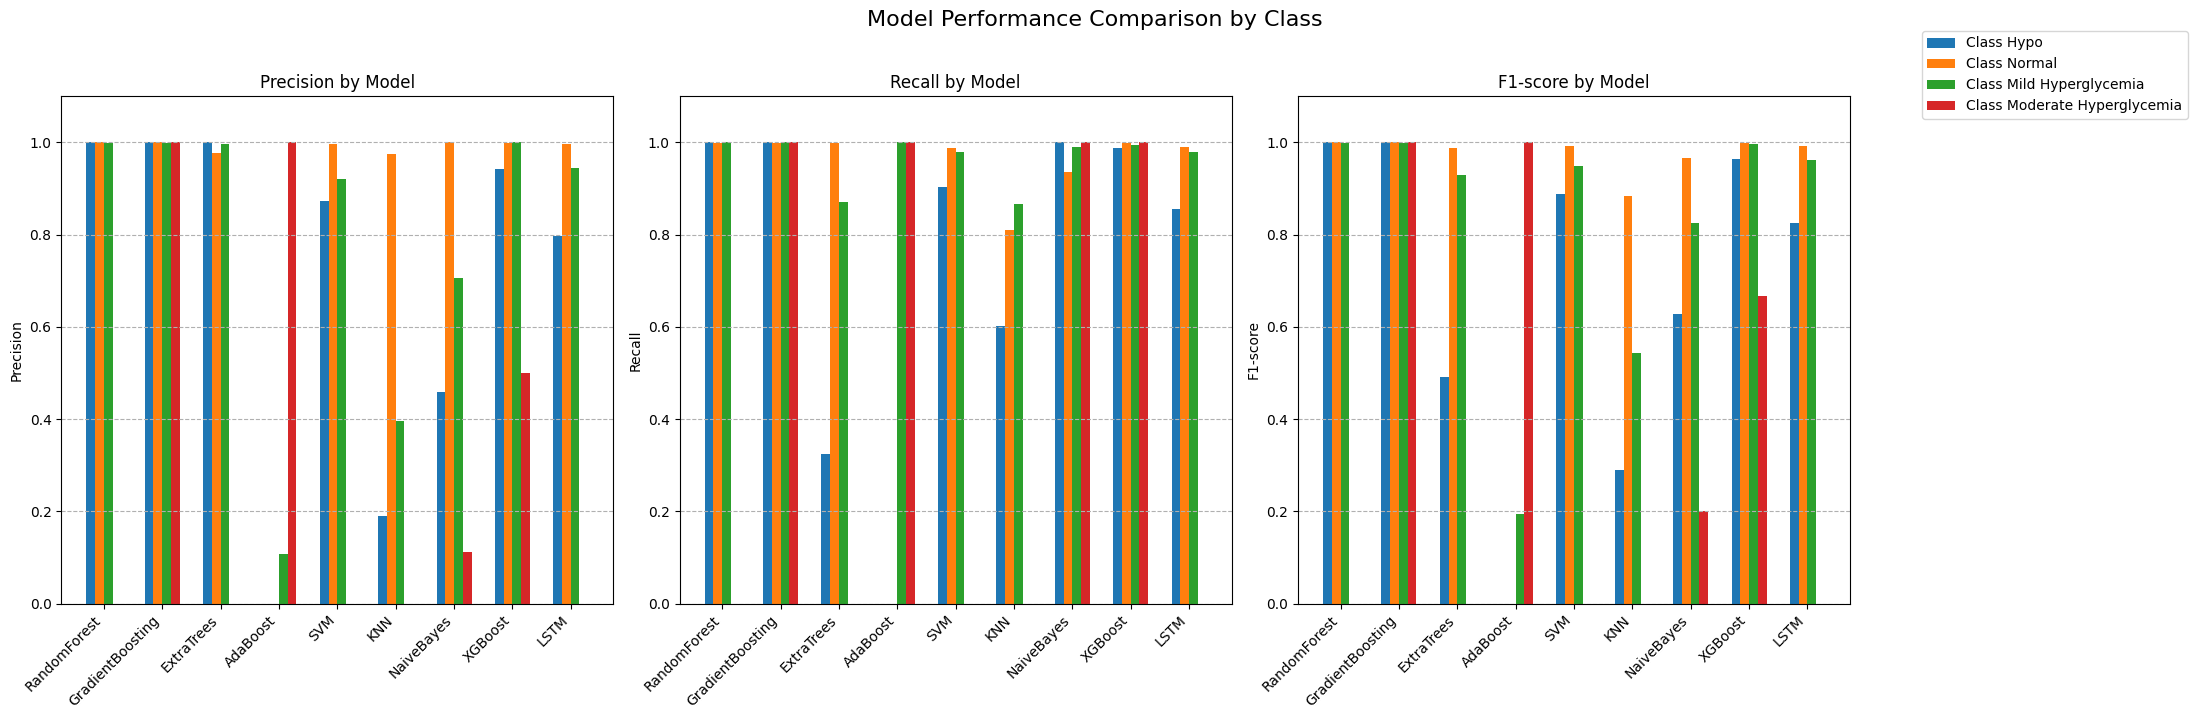

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
metrics = ['precision', 'recall', 'f1-score']
severity_labels = ['Hypo', 'Normal', 'Mild Hyperglycemia', 'Moderate Hyperglycemia', 'Severe Hyperglycemia']
severity_classes = [0, 1, 2, 3]

plt.figure(figsize=(22, 7)) # Adjusted figure size

for i, metric in enumerate(metrics, 1): # Start enumeration from 1
    plt.subplot(1, 3, i) # Arrange subplots in a row
    bar_positions = np.arange(len(model_names))
    bar_width = 0.15

    for j, cls in enumerate(severity_classes):
        values = []
        for model_name in model_names:
            value = results[model_name]["report"].get(str(cls), {}).get(metric, 0)
            values.append(value)

        plt.bar(bar_positions + j * bar_width, values, width=bar_width, label=f'Class {severity_labels[cls]}')

    plt.title(f'{metric.capitalize()} by Model')
    plt.xticks(bar_positions + bar_width * (len(severity_classes) - 1) / 2, model_names, rotation=45, ha='right')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1.1) # Set y-axis limits
    plt.grid(axis='y', linestyle='--')

handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))


plt.suptitle('Model Performance Comparison by Class', y=1.02, fontsize=16) # Add main title
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

plt.savefig('enhanced_model_comparison.png') # Save the figure
plt.show()

Skipping ROC plot for KNN - Class 3: Not enough variability in predictions or no true positives.


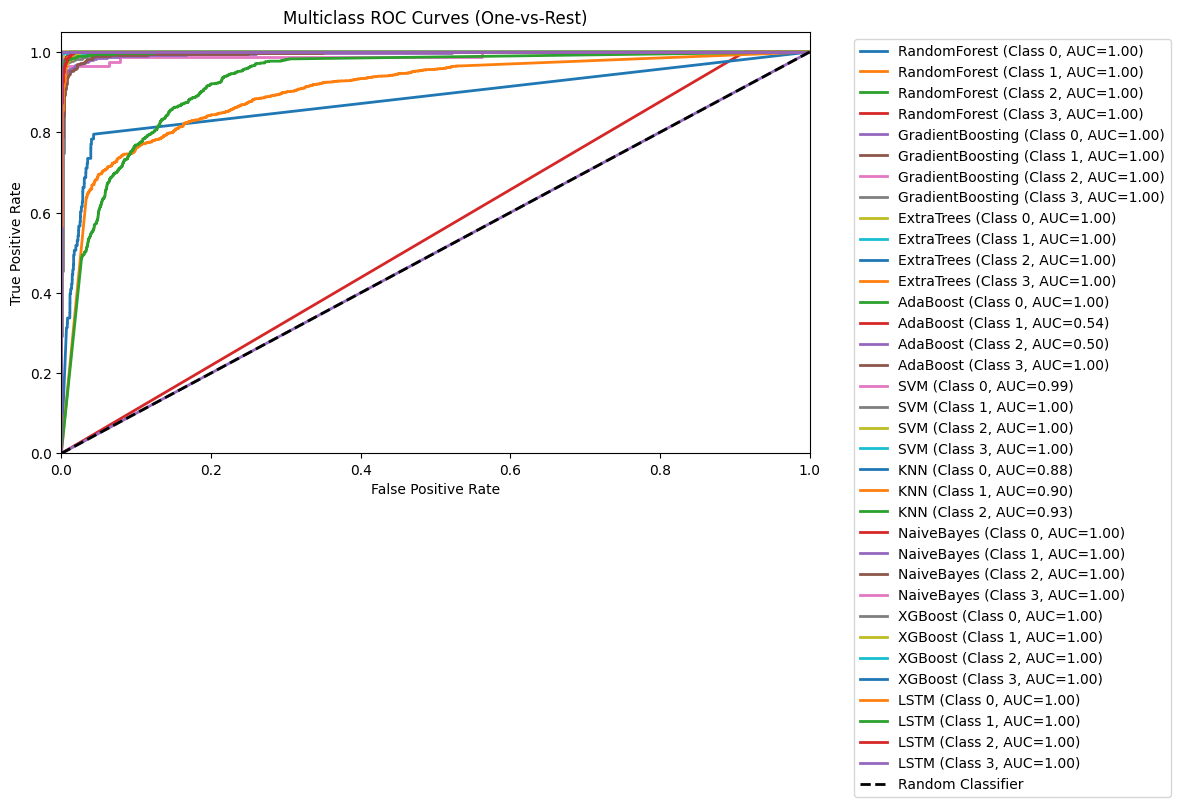

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


# Define the correct class labels
all_classes = [0, 1, 2, 3]

# Binarize the y_test data for multi-class ROC
y_test_bin = label_binarize(y_test, classes=all_classes)
n_classes = y_test_bin.shape[1]

# Create a figure for the ROC plots
plt.figure(figsize=(12, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple'])

# Iterate through each trained model
for model_name, data in results.items():
    pred_proba = data["pred_proba"]
    predicted_classes_in_report = [k for k in data["report"].keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    predicted_classes_in_report = [int(k) for k in predicted_classes_in_report] # Convert keys to integers
    temp_proba_df = pd.DataFrame(pred_proba, columns=predicted_classes_in_report)
    aligned_pred_proba = temp_proba_df.reindex(columns=all_classes, fill_value=0).values

    # Iterate through each class (0, 1, 2, 3)
    for i, cls in enumerate(all_classes):
        # Check if the class was present in the model's predictions at all
        # If a class was never predicted, the corresponding column in aligned_pred_proba will be all zeros
        # ROC curve calculation needs at least one positive and one negative example.
        # If the true class (y_test_bin[:, i]) has no positives OR the predicted probabilities are all 0/same value, skip plotting
        if np.sum(y_test_bin[:, i]) > 0 and not np.all(aligned_pred_proba[:, i] == aligned_pred_proba[0, i]):
             # Calculate FPR and TPR for the current class
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], aligned_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)

            # Plot the ROC curve
            plt.plot(fpr, tpr, lw=2,
                     label=f'{model_name} (Class {cls}, AUC={roc_auc:.2f})')
        else:
            print(f"Skipping ROC plot for {model_name} - Class {cls}: Not enough variability in predictions or no true positives.")


# Add a diagonal dashed line representing a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

# Set the plot limits, labels, and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-Rest)')

# Add a legend, adjusting its position to avoid overlapping the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Ensure the layout is tight and save the figure
plt.tight_layout()
plt.savefig('multiclass_roc_curves_updated.png')

# Display the plot
plt.show()

Skipping PR plot for KNN - Class 3: Not enough variability in predictions or no true positives.


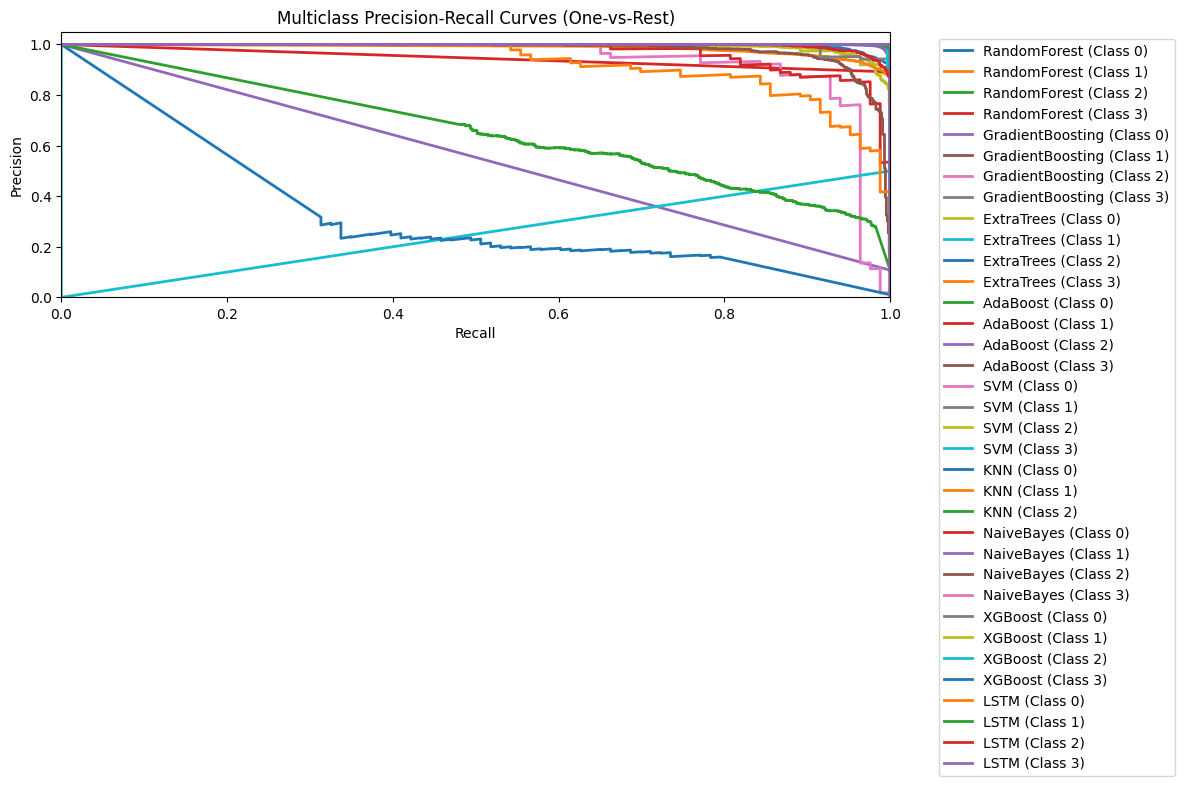

In [ ]:
from sklearn.metrics import precision_recall_curve
from itertools import cycle
from sklearn.preprocessing import label_binarize


# Define the correct class labels
all_classes = [0, 1, 2, 3]
y_test_bin = label_binarize(y_test, classes=all_classes)
n_classes = y_test_bin.shape[1]
plt.figure(figsize=(12, 6))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

# Iterate through each trained model
for model_name, data in results.items():
    pred_proba = data["pred_proba"]

    # Get the class labels predicted by the model from the report keys
    # Exclude 'accuracy', 'macro avg', 'weighted avg'
    predicted_classes_in_report = [k for k in data["report"].keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    predicted_classes_in_report = [int(k) for k in predicted_classes_in_report] # Convert keys to integers
    temp_proba_df = pd.DataFrame(pred_proba, columns=predicted_classes_in_report)
    aligned_pred_proba = temp_proba_df.reindex(columns=all_classes, fill_value=0).values

    # Iterate through each class (0, 1, 2, 3)
    for i, cls in enumerate(all_classes):
        # Check if there are true positive instances for this class in the test set
        # Check if there is variability in the predicted probabilities for this class
        if np.sum(y_test_bin[:, i]) > 0 and not np.all(aligned_pred_proba[:, i] == aligned_pred_proba[0, i]):
            # Calculate precision, recall for the current class
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], aligned_pred_proba[:, i])

            # Plot the Precision-Recall curve
            plt.plot(recall, precision, lw=2,
                     label=f'{model_name} (Class {cls})')
        else:
            print(f"Skipping PR plot for {model_name} - Class {cls}: Not enough variability in predictions or no true positives.")


# Set the plot labels, title, and limits
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curves (One-vs-Rest)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add a legend, adjusting its position to avoid overlapping the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Ensure the layout is tight and save the figure
plt.tight_layout()
plt.savefig('multiclass_precision_recall_curves_updated.png')

# Display the plot
plt.show()

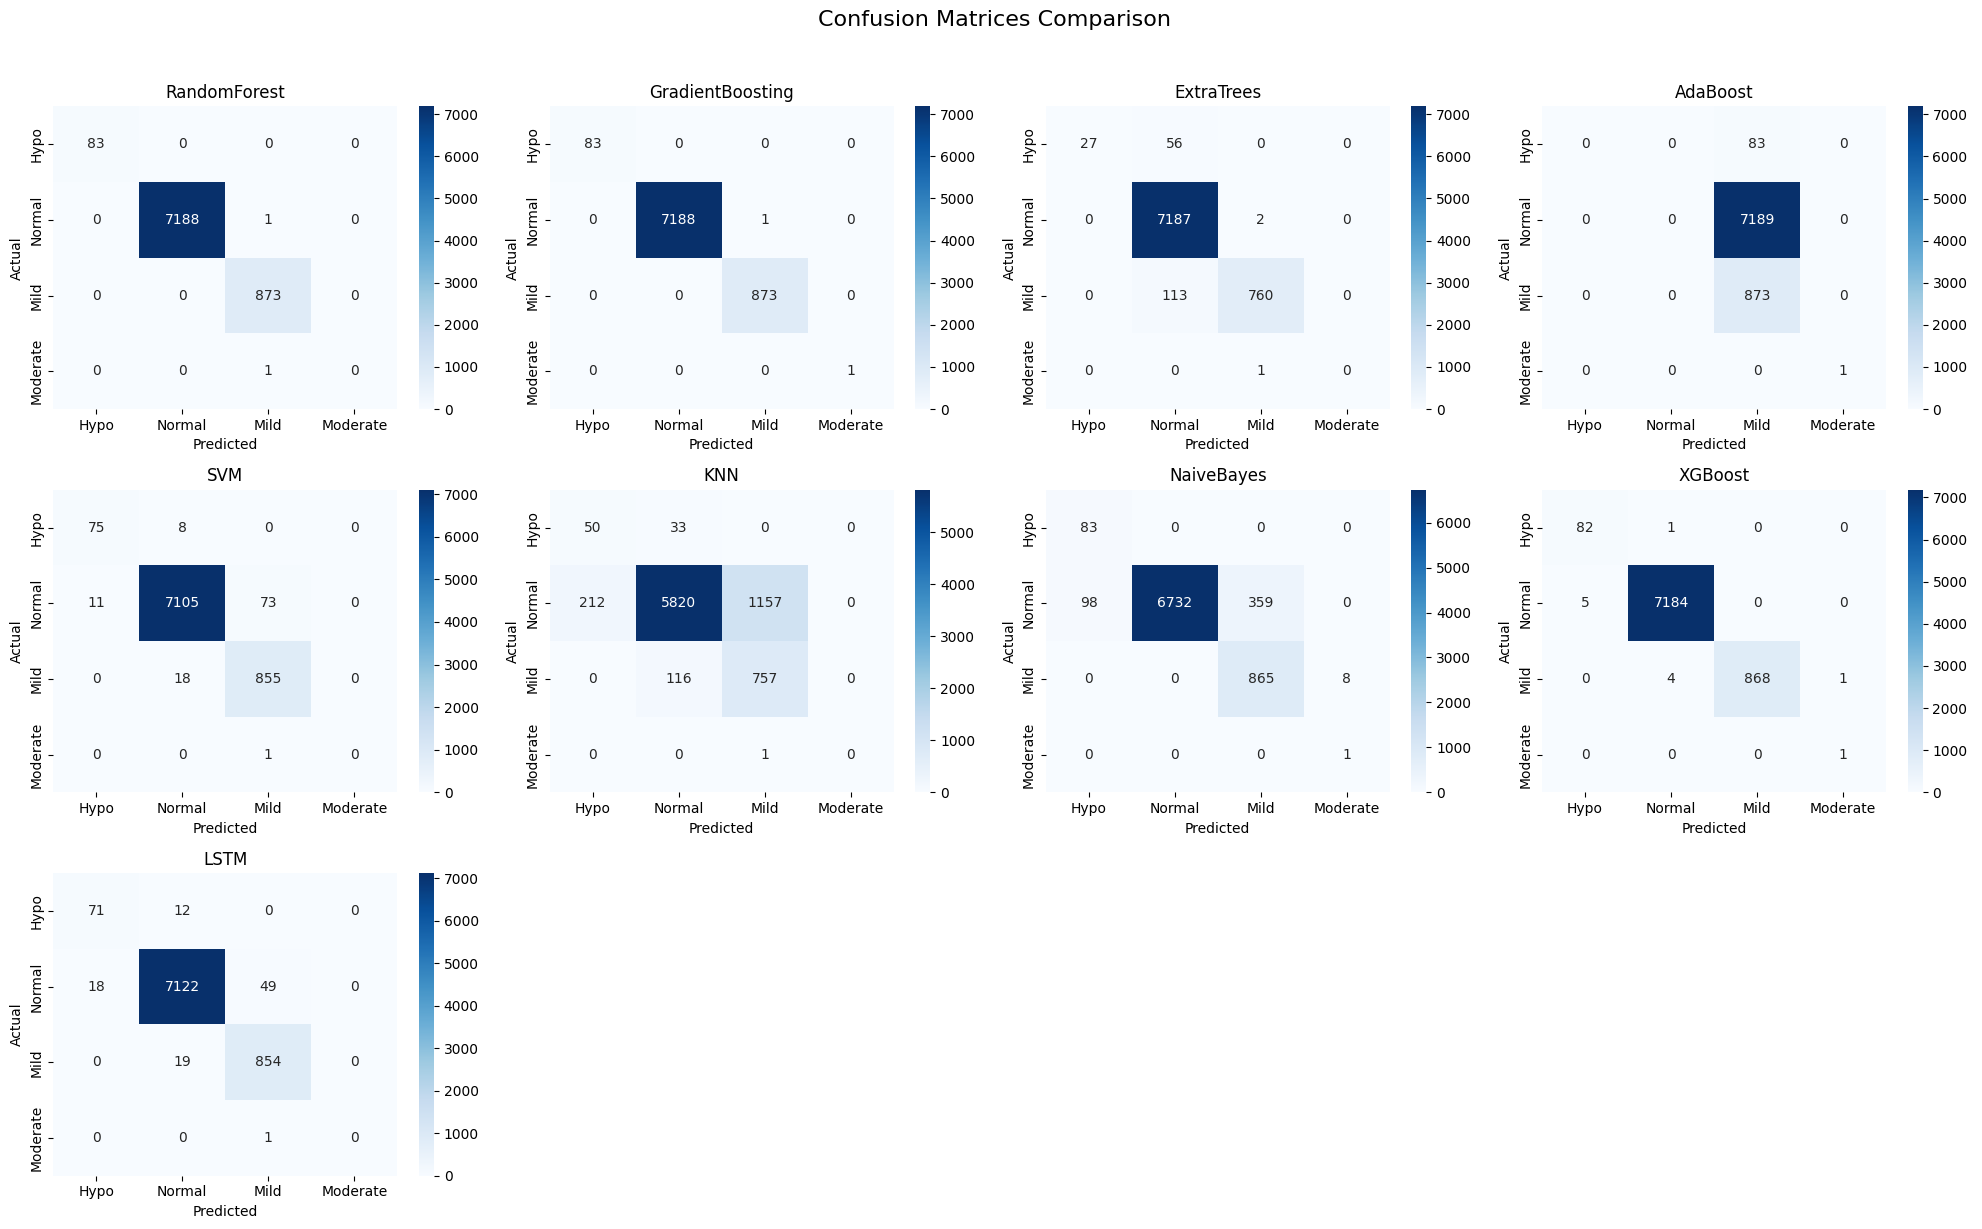

In [ ]:
# Define the correct severity labels for plotting
severity_labels = ['Hypo', 'Normal', 'Mild', 'Moderate', 'Severe']

# The confusion matrices are calculated based on the predicted classes vs true classes.
# The classification report and confusion matrices from previous steps used classes 0, 1, 2, 3
# So, the labels for the confusion matrix axes should correspond to these classes.
severity_classes_for_axes = [0, 1, 2, 3]
severity_labels_for_axes = [severity_labels[cls] for cls in severity_classes_for_axes]


model_names = list(results.keys())
n_models = len(model_names)

#  grid size
n_cols = 4 # Max columns per row
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.ravel()


for i, model_name in enumerate(model_names):

    cm = results[model_name]["confusion_matrix"]


    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=severity_labels_for_axes,
                yticklabels=severity_labels_for_axes)
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')


for j in range(i + 1, len(axes)):
    axes[j].axis('off')


fig.suptitle('Confusion Matrices Comparison', y=1.02, fontsize=16)

plt.tight_layout()

plt.savefig('confusion_matrices_grid.png')

plt.show()

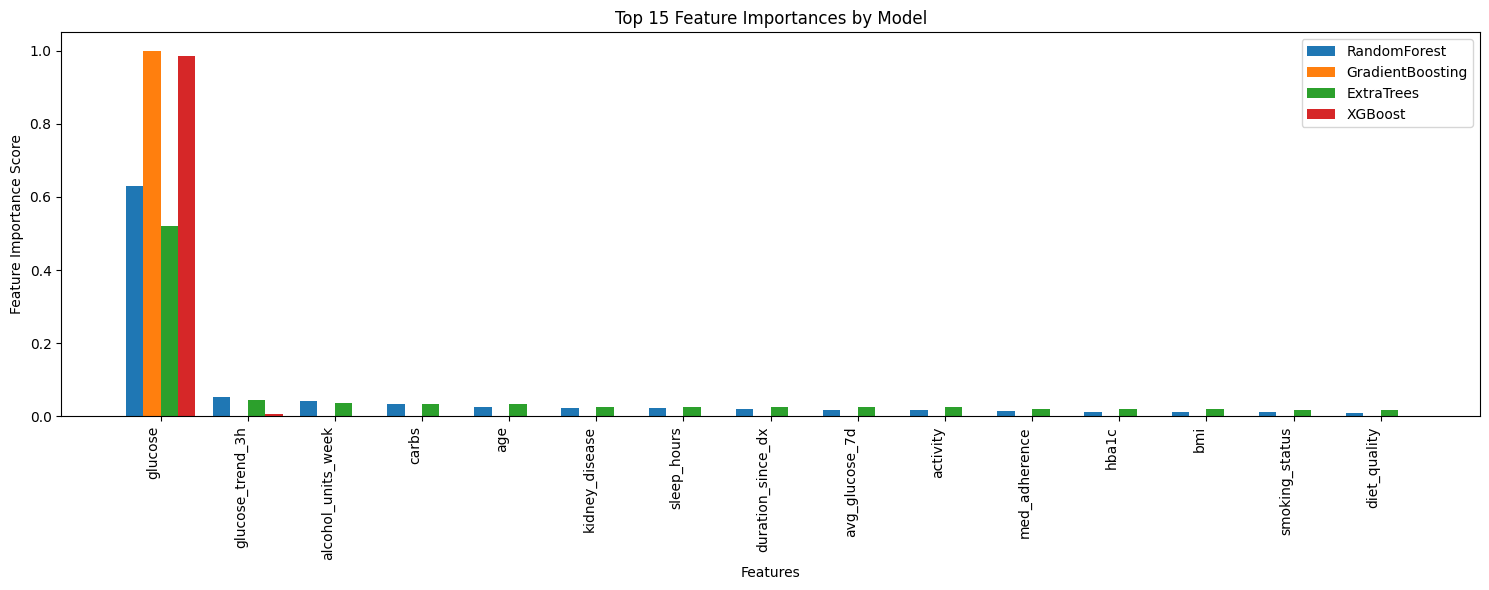

In [ ]:
# Define models that provide feature importances
importance_models = ['RandomForest', 'GradientBoosting', 'ExtraTrees', 'XGBoost']

# Create a new figure and axes
plt.figure(figsize=(15, 6))

# Get the list of feature columns (defined in the previous cell)
# feature_cols = [
#     "glucose", "carbs", "insulin", "activity", "stress", "time_of_day",
#     "age", "bmi", "hba1c", "hypertension", "kidney_disease", "type_diabetes",
#     "duration_since_dx", "sleep_hours", "diet_quality", "smoking_status",
#     "alcohol_units_week", "med_adherence", "glucose_trend_3h",
#     "avg_glucose_7d", "time_since_last_insulin", "hyper_events_past_week"
# ]

# Number of top features to display
top_n = 15

# Bar width for plotting
bar_width = 1.0 / (len(importance_models) + 1)


for i, model_name in enumerate(importance_models):
    # Retrieve feature importances
    if model_name in feat_imp_dict:
        importances = feat_imp_dict[model_name]

        importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importances
        })

        # Sort by importance in descending order
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

        # Get feature names and importance values
        features = importance_df['Feature']
        values = importance_df['Importance']

        # Create a numerical position for each feature for plotting
        x_positions = np.arange(len(features))

        # Plot the bars
        plt.bar(x_positions + i * bar_width, values, width=bar_width, label=model_name)
    else:
        print(f"Feature importances not found for {model_name}. Skipping.")


# Add titles and labels
plt.title(f'Top {top_n} Feature Importances by Model')
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.xticks(x_positions + (len(importance_models) - 1) * bar_width / 2, features, rotation=90, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('feature_importance_comparison.png')
plt.show()

In [ ]:
!pip install streamlit pyngrok joblib tensorflow

In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import os
import plotly.graph_objects as go


# Load Logistic Regression Model

MODEL_FILE = "LogisticRegression_Multinomial_model.pkl"

if not os.path.exists(MODEL_FILE):
    st.error(f" Logistic Regression model file '{MODEL_FILE}' not found. Please upload it.")
else:
    model, scaler = joblib.load(MODEL_FILE)


    # Page Setup

    st.set_page_config(page_title="Hyperglycemia Risk Calculator", page_icon="🩺", layout="wide")
    st.title("🩺 Logistic Regression Hyperglycemia Risk Calculator")
    st.markdown("Enter patient details to get hyperglycemia risk predictions.")


    # Feature Input

    with st.form("risk_form"):
        col1, col2 = st.columns(2)

        with col1:
            glucose = st.number_input("Glucose (mg/dL)", 50, 400, 120)
            carbs = st.number_input("Carbs intake (g)", 0, 300, 50)
            insulin = st.number_input("Insulin dose (units)", 0, 100, 10)
            activity = st.number_input("Activity (mins/day)", 0, 300, 30)
            stress = st.slider("Stress Level (0=Low, 10=High)", 0, 10, 5)
            time_of_day = st.selectbox("Time of Day", [0, 1, 2, 3])
            age = st.number_input("Age", 1, 100, 40)
            bmi = st.number_input("BMI", 10.0, 50.0, 25.0)

        with col2:
            hba1c = st.number_input("HbA1c (%)", 4.0, 15.0, 7.0)
            hypertension = st.selectbox("Hypertension (0=No, 1=Yes)", [0, 1])
            kidney_disease = st.selectbox("Kidney Disease (0=No, 1=Yes)", [0, 1])
            type_diabetes = st.selectbox("Type of Diabetes (1=Type1, 2=Type2)", [1, 2])
            duration_since_dx = st.number_input("Duration Since Diagnosis (yrs)", 0, 50, 5)
            sleep_hours = st.number_input("Sleep Hours", 0, 15, 7)
            diet_quality = st.slider("Diet Quality (1=Poor, 10=Excellent)", 1, 10, 6)
            smoking_status = st.selectbox("Smoking Status (0=Non-smoker, 1=Smoker)", [0, 1])

        col3, col4 = st.columns(2)
        with col3:
            alcohol_units_week = st.number_input("Alcohol Units/Week", 0, 50, 2)
            med_adherence = st.slider("Medication Adherence (0=Poor, 10=Excellent)", 0, 10, 8)
            glucose_trend_3h = st.number_input("Glucose Trend Last 3h (mg/dL change)", -100, 100, 0)
        with col4:
            avg_glucose_7d = st.number_input("Average Glucose (last 7 days)", 50, 400, 150)
            time_since_last_insulin = st.number_input("Time Since Last Insulin (hrs)", 0, 48, 6)
            hyper_events_past_week = st.number_input("Hyperglycemia Events (past week)", 0, 10, 1)

        submit_btn = st.form_submit_button("Calculate Risk")


    # Prediction Logic

    if submit_btn:
        risk_colors = {
            "Low Risk": "green",
            "Moderate Risk": "orange",
            "High Risk": "red",
            "Hypoglycemia": "blue",
            "Normal": "green",
            "Unknown": "gray"  # Fallback color
        }

        # Rule-based override
        if 50 <= glucose <= 80:
            risk_label = "Hypoglycemia"
            pred_probs = None
            suggestion = "Immediate carbohydrate intake and monitoring. Consult healthcare provider if symptoms persist."
            st.warning(" Glucose level indicates **Hypoglycemia**.")

        elif 80 < glucose <= 120:
            risk_label = "Normal"
            pred_probs = None
            suggestion = "Maintain healthy lifestyle and regular monitoring."
            st.success(" Glucose level is **Normal**.")

        elif glucose >= 125:
            input_data = np.array([[
                glucose, carbs, insulin, activity, stress, time_of_day,
                age, bmi, hba1c, hypertension, kidney_disease, type_diabetes,
                duration_since_dx, sleep_hours, diet_quality, smoking_status,
                alcohol_units_week, med_adherence, glucose_trend_3h,
                avg_glucose_7d, time_since_last_insulin, hyper_events_past_week
            ]])

            input_scaled = scaler.transform(input_data)
            pred_probs = model.predict_proba(input_scaled)[0]
            pred_class = np.argmax(pred_probs)

            risk_map = {0: "Low Risk", 1: "Moderate Risk", 2: "High Risk"}
            risk_label = risk_map.get(pred_class, "Unknown")

            suggestion_map = {
                "Low Risk": "Maintain current lifestyle, regular monitoring, follow-up every 3–6 months.",
                "Moderate Risk": "Review diet, increase physical activity, monitor glucose daily, consult physician within a month.",
                "High Risk": "Immediate review by healthcare provider, possible medication adjustment, frequent monitoring (4+ times/day).",
                "Hypoglycemia": "Immediate carbohydrate intake and monitoring. Consult healthcare provider if symptoms persist.",
                "Normal": "Maintain healthy lifestyle and regular monitoring.",
                "Unknown": "Model could not determine risk. Please retest or consult a doctor."
            }
            suggestion = suggestion_map.get(risk_label, "No suggestion available.")


        # Display Results

        st.subheader(" Prediction Results")
        st.markdown(
            f"**Predicted Risk Category:** <span style='color:{risk_colors.get(risk_label, 'gray')}; font-size:20px;'>{risk_label}</span>",
            unsafe_allow_html=True
        )

        if pred_probs is not None:
            st.write(f"**Prediction Confidence:** {pred_probs[np.argmax(pred_probs)]*100:.2f}%")

        st.markdown(f"**Clinical Suggestion:** {suggestion}")

        if pred_probs is not None:
            fig = go.Figure()
            for i, risk in enumerate(["Low Risk", "Moderate Risk", "High Risk"]):
                fig.add_trace(go.Bar(
                    x=[risk],
                    y=[pred_probs[i]],
                    text=[f"{pred_probs[i]*100:.1f}%"],
                    textposition="auto",
                    marker_color=risk_colors.get(risk, "gray"),
                    name=risk
                ))

            fig.update_layout(
                title="Risk Probability Distribution",
                yaxis_title="Probability",
                xaxis_title="Risk Category",
                template="plotly_white"
            )

            st.plotly_chart(fig, use_container_width=True)

Overwriting app.py


In [ ]:
from pyngrok import ngrok

# Close any previous tunnels
ngrok.kill()

# Set ngrok authtoken
# Replace 'YOUR_AUTHTOKEN' with your actual ngrok authtoken
# You can get one from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("30hlm01d4g13zGqCq0K8Drq6BHL_4TFHLeqvpMv3kfgKjwkmB")


# Open new tunnel for Streamlit
public_url = ngrok.connect(addr=8501)
print(f" App running at: {public_url}")

# Run the Streamlit app in the background
!streamlit run app.py --server.port 8501 &>/dev/null&

 App running at: NgrokTunnel: "https://28828f84dd20.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
from graphviz import Digraph

dot = Digraph(comment="Data Flow for Hyperglycaemia Prediction System")

# Nodes
dot.node('A', 'User Input\n(Age, Glucose, BMI, etc.)')
dot.node('B', 'Preprocessing\n(Normalisation, Encoding)')
dot.node('C', 'ML Model\n(Logistic Regression, etc.)')
dot.node('D', 'Prediction\n(Risk Category)')
dot.node('E', 'Clinical Recommendation\n(Advice Mapping)')
dot.node('F', 'PDF Export / UI Output')

# Edges
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Save and render
dot.render('data_flow_diagram', format='png', cleanup=True)

'data_flow_diagram.png'

In [ ]:
from graphviz import Digraph

dot = Digraph(comment="Use Case Diagram")

# Actors
dot.node('P', 'Patient', shape='ellipse', color='lightblue')
dot.node('C', 'Clinician', shape='ellipse', color='lightgreen')

# Use cases
dot.node('UC1', 'Enter health data', shape='rect')
dot.node('UC2', 'Receive risk prediction', shape='rect')
dot.node('UC3', 'Download PDF report', shape='rect')
dot.node('UC4', 'Review model performance', shape='rect')
dot.node('UC5', 'Adjust clinical recommendations', shape='rect')

# Relationships
dot.edge('P', 'UC1')
dot.edge('P', 'UC2')
dot.edge('P', 'UC3')
dot.edge('C', 'UC2')
dot.edge('C', 'UC4')
dot.edge('C', 'UC5')

# Save and render
dot.render('use_case_diagram', format='png', cleanup=True)

'use_case_diagram.png'

In [ ]:
from graphviz import Digraph

dot = Digraph(comment="Hyperglycemia Prediction System Architecture")

# Nodes
dot.node('UI', 'User Interface\n(Streamlit App)', shape='box', style='filled', color='lightblue')
dot.node('PRE', 'Preprocessing Module\n(Normalisation, Encoding, SMOTE)', shape='box', style='filled', color='lightyellow')
dot.node('MODEL', 'Prediction Model\n(Logistic Regression / Others)', shape='box', style='filled', color='lightgreen')
dot.node('REC', 'Clinical Recommendation\n(Risk-based Advice)', shape='box', style='filled', color='lightpink')
dot.node('PDF', 'PDF Export Module', shape='box', style='filled', color='lightgrey')

# Edges
dot.edge('UI', 'PRE', label='Collect user data')
dot.edge('PRE', 'MODEL', label='Processed data')
dot.edge('MODEL', 'REC', label='Predicted risk')
dot.edge('REC', 'UI', label='Display result')
dot.edge('REC', 'PDF', label='Save report')

# Save and render
dot.render('system_architecture', format='png', cleanup=True)

'system_architecture.png'